/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:37:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:37:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:37:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:37:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa


=== Results (DL, XGB, PPO Static/Seq, MoE) ===
 Accuracy  Precision   Recall  F1-Score                                        Model  Time (s)
 0.993424   0.993430 0.993424  0.993426                             PPO (Sequential)     22.55
 0.993424   0.993416 0.993424  0.993406                                 PPO (Static)     14.25
 0.992986   0.992974 0.992986  0.992969                                      XGBoost      0.00
 0.992986   0.992974 0.992986  0.992969 Mixture-of-Experts (Gating MLP, route-aware)      0.00
 0.984656   0.984645 0.984656  0.984650                                      Bi-LSTM     39.79
 0.983779   0.983730 0.983779  0.983747                                          CNN      4.37
 0.978518   0.978822 0.978518  0.978624                                 Stacked LSTM     15.99
 0.956598   0.960999 0.956598  0.957642                                         LSTM     12.02


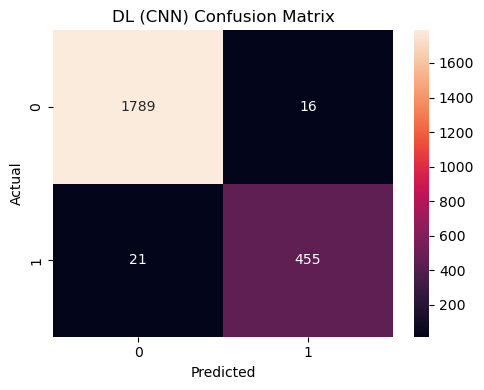

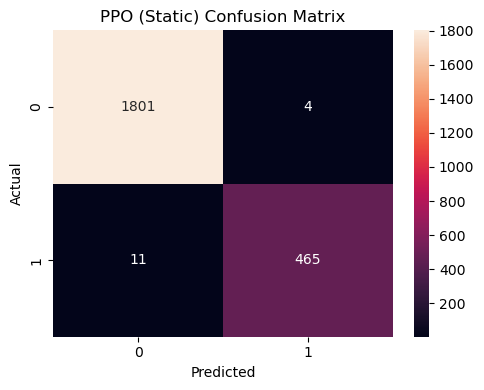

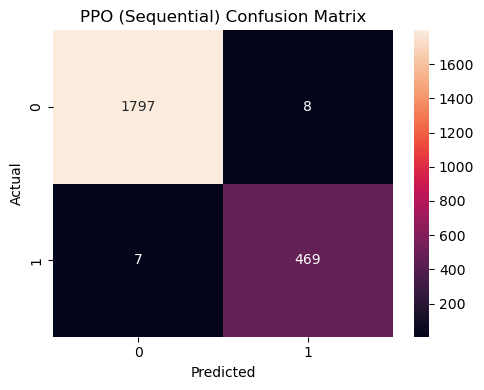

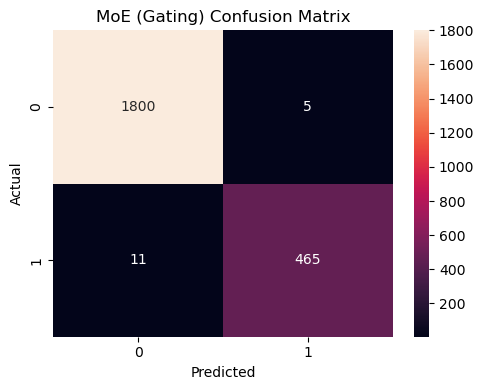

In [ ]:
# =========================
# Hybrid DL + PPO + Mixture of Experts (MoE)
# =========================
import os
import time
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Bidirectional, Flatten, Input, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

file_path = os.path.join("Data", "Hybrid_Augmented_TSAFE_Features.xlsx")
df = pd.read_excel(file_path)

if 'Plant_Destination' not in df.columns:
    if {'Plant Code', 'Destination Port'}.issubset(df.columns):
        df['Plant_Destination'] = (
            df['Plant Code'].astype(str) + ' | ' + df['Destination Port'].astype(str)
        )
    else:
        raise ValueError("Cannot create 'Plant_Destination' because 'Plant Code' or 'Destination Port' is missing.")

cat_features = [
    'Origin Port',
    'Carrier',
    'Plant Code',
    'Destination Port',
    'Plant_Destination',       # NEW (categorical)
]

num_features = [
    # Raw operational measures
    'Unit quantity',
    'Weight',
    'TPT',

    # Empirically validated augmented features
    'TPT_per_Unit',            # p<0.001, SHAP rank #10
    'LeadTime_Deviation',      # p<0.001, SHAP rank #2
    'Weight_per_Unit',         # SHAP rank #6
    'log_UnitQty',             # SHAP rank #3 (interaction)
    'carrier_origin_risk',     # p<0.001, SHAP rank #1
    'route_cum_late_rate',     # p<0.001, SHAP rank #4
    'route_bb_mean',           # p<0.001, SHAP rank #12
    'carrier_bb_mean',         # p<0.001, SHAP rank #13
    'route_orders_last7d',     # p<0.001, SHAP rank #9
    'route_roll10_Weight_q90', # p=0.0053, SHAP rank #7

    # NEW (from your stats/SHAP list)
    'congestion_trend',
    'Weight_vsCarrierMean',
    'seq_pos_norm',
]

requested_cols = cat_features + num_features
missing = [c for c in requested_cols if c not in df.columns]
if missing:
    print(f"[WARN] These requested columns are missing and will be skipped: {missing}")
    cat_features = [c for c in cat_features if c in df.columns]
    num_features = [c for c in num_features if c in df.columns]

X = pd.get_dummies(df[cat_features + num_features], drop_first=False)
y = (df['Ship Late Day count'] > 0).astype(int)  # binary target

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

# === 1.3) Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)

def calculate_metrics(y_true, y_score_or_pred):
    """Accepts probabilities or hard labels. If not in {0,1}, threshold @0.5."""
    arr = np.asarray(y_score_or_pred).reshape(-1)
    if set(np.unique(arr)) <= {0,1}:
        y_pred = arr.astype(int)
    else:
        y_pred = (arr >= 0.5).astype(int)
    return {
        'Accuracy':  accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=1),
        'Recall':    recall_score(y_true, y_pred, average='weighted', zero_division=1),
        'F1-Score':  f1_score(y_true, y_pred, average='weighted', zero_division=1)
    }

xgb = GridSearchCV(
    estimator=XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    ),
    param_grid={
        'n_estimators': [100],
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.05],
        'subsample': [0.8]
    },
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_proba = xgb.best_estimator_.predict_proba(X_test)[:, 1]
xgb_metrics = calculate_metrics(y_test, xgb_proba)

def create_model(model_type, input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim, 1)))
    if model_type == 'CNN':
        model.add(Conv1D(64, 2, activation='relu'))
        model.add(Flatten())
    elif model_type == 'LSTM':
        model.add(LSTM(64, activation='tanh'))
    elif model_type == 'Bi-LSTM':
        model.add(Bidirectional(LSTM(64, activation='tanh')))
    elif model_type == 'Stacked LSTM':
        model.add(LSTM(64, activation='tanh', return_sequences=True))
        model.add(LSTM(32, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=1e-3, clipnorm=1.0), loss='binary_crossentropy')
    return model

X_train_dl = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_dl  = X_test_scaled.reshape(-1,  X_test_scaled.shape[1],  1)

dl_models = ['CNN', 'LSTM', 'Bi-LSTM', 'Stacked LSTM']
results = []
dl_outputs = {}  # store probabilities

for m in dl_models:
    mdl = create_model(m, X_train_dl.shape[1])
    t0 = time.time()
    mdl.fit(X_train_dl, y_train_res, epochs=10, batch_size=256, verbose=0)
    duration = round(time.time() - t0, 2)
    proba = mdl.predict(X_test_dl, verbose=0).reshape(-1)
    dl_outputs[m] = proba
    met = calculate_metrics(y_test, proba)
    met.update({'Model': m, 'Time (s)': duration})
    results.append(met)

xgb_met = xgb_metrics.copy()
xgb_met.update({'Model': 'XGBoost', 'Time (s)': 0.0})
results.append(xgb_met)

ppo_input_static = np.vstack([
    xgb_proba,
    dl_outputs['CNN'],
    dl_outputs['LSTM'],
    dl_outputs['Bi-LSTM'],
    dl_outputs['Stacked LSTM']
]).T.astype(np.float32)

ppo_input_static = MinMaxScaler().fit_transform(ppo_input_static).astype(np.float32)
ppo_labels_static = y_test.values.astype(int)

class PPOHybridEnv(gym.Env):
    """
    Static classification PPO (independent rows).
    Observation: (5,) stacked model outputs in [0,1].
    Action: {0,1}. Reward: +1 correct, -5 incorrect (cost-sensitive).
    """
    metadata = {"render_modes": []}

    def __init__(self, inputs, labels, pos_reward=1.0, neg_reward=-5.0):
        super().__init__()
        self.inputs = inputs
        self.labels = labels
        self.n = len(labels)
        self.pos_reward = pos_reward
        self.neg_reward = neg_reward
        self.observation_space = spaces.Box(low=0, high=1, shape=(inputs.shape[1],), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.idx = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.idx = 0
        return self.inputs[self.idx], {}

    def step(self, action):
        reward = self.pos_reward if action == self.labels[self.idx] else self.neg_reward
        self.idx += 1
        terminated = self.idx >= self.n
        obs = np.zeros(self.inputs.shape[1], dtype=np.float32) if terminated else self.inputs[self.idx]
        return obs, float(reward), terminated, False, {}


env_static = make_vec_env(lambda: PPOHybridEnv(ppo_input_static, ppo_labels_static), n_envs=1)
ppo_model_static = PPO("MlpPolicy", env_static, verbose=0, seed=42)
t0 = time.time()
ppo_model_static.learn(total_timesteps=50_000)
ppo_static_time = round(time.time() - t0, 2)


env_eval_static = PPOHybridEnv(ppo_input_static, ppo_labels_static)
obs, _ = env_eval_static.reset()
ppo_preds_static = []
done = False
while not done:
    action, _ = ppo_model_static.predict(obs, deterministic=True)
    ppo_preds_static.append(int(action))
    obs, _, done, _, _ = env_eval_static.step(action)

ppo_metrics_static = calculate_metrics(ppo_labels_static, np.array(ppo_preds_static))
ppo_metrics_static.update({'Model': 'PPO (Static)', 'Time (s)': ppo_static_time})
results.append(ppo_metrics_static)


meta_cols = [c for c in ['Order Date', 'Origin Port', 'Destination Port', 'Carrier'] if c in df.columns]
if len(meta_cols) < 4:
   
    df_fallback = df.copy()
    if 'Order Date' not in df_fallback.columns:
        df_fallback['Order Date'] = pd.Timestamp('2000-01-01')
    for cc in ['Origin Port', 'Destination Port', 'Carrier']:
        if cc not in df_fallback.columns:
            df_fallback[cc] = 'UNK'
    base_df = df_fallback
else:
    base_df = df

test_idx = X_test.index
test_frame = base_df.loc[test_idx, ['Order Date', 'Origin Port', 'Destination Port', 'Carrier']].copy()
test_frame['Order Date'] = pd.to_datetime(test_frame['Order Date'], errors='coerce').fillna(pd.Timestamp('2000-01-01'))


test_frame['y']       = y_test.values.astype(int)
test_frame['xgb']     = xgb_proba
for m in dl_models:
    test_frame[m] = dl_outputs[m]


test_frame['route_key'] = (
    test_frame['Origin Port'].astype(str) + ' | ' +
    test_frame['Destination Port'].astype(str) + ' | ' +
    test_frame['Carrier'].astype(str)
)


test_frame = test_frame.sort_values('Order Date').reset_index(drop=True)

base_inputs = test_frame[['xgb', 'CNN', 'LSTM', 'Bi-LSTM', 'Stacked LSTM']].values.astype(np.float32)
base_inputs = MinMaxScaler().fit_transform(base_inputs).astype(np.float32)
labels_sorted = test_frame['y'].values.astype(int)
route_sorted  = test_frame['route_key'].values

episodes = []
start = 0
for i in range(1, len(test_frame) + 1):
    if i == len(test_frame) or route_sorted[i] != route_sorted[i-1]:
        episodes.append(slice(start, i))
        start = i

class SequentialPPOEnv(gym.Env):
    """
    Sequential PPO with temporal state and cost-sensitive rewards.

    Observation = [base_inputs(5), time_sin, time_cos, last_K_actions(K), cum_FP, cum_FN]
    Action      = {0,1}
    Reward:
        +2 correct late (TP), +1 correct on-time (TN)
        -5 false negative (missed late), -2 false positive
        -0.01 step penalty; +0.2 bonus if FN-rate improves vs. previous step
    Episodes follow route continuity in time.
    """
    metadata = {"render_modes": []}

    def __init__(self, base_inputs, labels, episodes, K=5):
        super().__init__()
        self.base_inputs = base_inputs
        self.labels = labels.astype(int)
        self.episodes = episodes
        self.K = K

        self.obs_dim = 5 + 2 + K + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)

        self._ep_idx = -1
        self._indices = None
        self._t = None
        self._last_actions = None
        self._cum_fp = None
        self._cum_fn = None
        self._prev_fn_rate = 0.0

    def _time_features(self, t, T):
        pos = (t / max(T - 1, 1))
        return np.array([np.sin(2*np.pi*pos), np.cos(2*np.pi*pos)], dtype=np.float32)

    def _obs(self):
        T = len(self._indices)
        cur_idx = self._indices[self._t]
        x = self.base_inputs[cur_idx]  # (5,)
        time_feat = self._time_features(self._t, T)  # (2,)
        lastK = self._last_actions.copy()  # (K,)
        obs = np.concatenate([x, time_feat, lastK, np.array([self._cum_fp, self._cum_fn], dtype=np.float32)], axis=0)
        return obs.astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._ep_idx = (self._ep_idx + 1) % len(self.episodes)
        sl = self.episodes[self._ep_idx]
        self._indices = np.arange(sl.start, sl.stop, dtype=int)
        self._t = 0
        self._last_actions = np.zeros(self.K, dtype=np.float32)
        self._cum_fp = 0.0
        self._cum_fn = 0.0
        self._prev_fn_rate = 0.0
        return self._obs(), {}

    def step(self, action):
        cur_i = self._indices[self._t]
        y = self.labels[cur_i]

        # Cost-sensitive reward
        if action == y:
            reward = 2.0 if y == 1 else 1.0
        else:
            if y == 1 and action == 0:
                reward = -5.0  # False Negative
                self._cum_fn += 1.0
            else:
                reward = -2.0  # False Positive
                self._cum_fp += 1.0

        reward -= 0.01  # small step penalty

   
        steps_so_far = float(self._t + 1)
        fn_rate = self._cum_fn / steps_so_far
        if fn_rate < self._prev_fn_rate:
            reward += 0.2
        self._prev_fn_rate = fn_rate

     
        self._last_actions = np.roll(self._last_actions, -1)
        self._last_actions[-1] = float(action)

      
        self._t += 1
        terminated = self._t >= len(self._indices)
        truncated = False

        obs = np.zeros(self.obs_dim, dtype=np.float32) if terminated else self._obs()
        return obs, float(reward), terminated, truncated, {}


env_seq = make_vec_env(lambda: SequentialPPOEnv(base_inputs, labels_sorted, episodes, K=5), n_envs=1)
ppo_model_seq = PPO("MlpPolicy", env_seq, verbose=0, seed=42)
t0 = time.time()
ppo_model_seq.learn(total_timesteps=80_000)
ppo_seq_time = round(time.time() - t0, 2)


eval_env = SequentialPPOEnv(base_inputs, labels_sorted, episodes, K=5)
obs, _ = eval_env.reset()
seq_preds = []
visited_episodes = 0
while True:
    action, _ = ppo_model_seq.predict(obs, deterministic=True)
    seq_preds.append(int(action))
    obs, _, terminated, truncated, _ = eval_env.step(action)
    if terminated:
        visited_episodes += 1
        if visited_episodes >= len(episodes):
            break
        obs, _ = eval_env.reset()

seq_preds = np.array(seq_preds[:len(labels_sorted)])
seq_metrics = calculate_metrics(labels_sorted, seq_preds)
seq_metrics.update({'Model': 'PPO (Sequential)', 'Time (s)': ppo_seq_time})
results.append(seq_metrics)


expert_names = ['xgb', 'CNN', 'LSTM', 'Bi-LSTM', 'Stacked LSTM']
expert_proba_test = np.vstack([
    xgb_proba,
    dl_outputs['CNN'],
    dl_outputs['LSTM'],
    dl_outputs['Bi-LSTM'],
    dl_outputs['Stacked LSTM']
]).T.astype(np.float32)   # shape: (n_test, 5)

route_onehot_cols = [c for c in X_test.columns
                     if c.startswith('Origin Port_') or c.startswith('Destination Port_')
                     or c.startswith('Carrier_') or c.startswith('Plant_Destination_')]

numeric_ctx_cands = [
    'carrier_origin_risk', 'route_cum_late_rate', 'LeadTime_Deviation',
    'TPT', 'Weight', 'Unit quantity'
]
numeric_ctx_cols = [c for c in numeric_ctx_cands if c in X_test.columns]


if len(numeric_ctx_cols) > 0:
    from sklearn.preprocessing import StandardScaler
    ctx_scaler = StandardScaler()
    ctx_scaler.fit(X_train_res[numeric_ctx_cols])
    ctx_num_test = ctx_scaler.transform(X_test[numeric_ctx_cols]).astype(np.float32)
else:
    ctx_num_test = np.empty((X_test.shape[0], 0), dtype=np.float32)

ctx_route_test = X_test[route_onehot_cols].values.astype(np.float32) if len(route_onehot_cols) > 0 else np.empty((X_test.shape[0], 0), dtype=np.float32)
context_test = np.hstack([ctx_route_test, ctx_num_test]).astype(np.float32)

if context_test.shape[1] == 0:
    context_test = expert_proba_test.copy()

def build_moe_gater(prob_dim: int, context_dim: int, hidden: int = 64, dropout: float = 0.2):
    probs_in = Input(shape=(prob_dim,),   name='probs_in')  # expert probabilities (5,)
    ctx_in   = Input(shape=(context_dim,), name='ctx_in')    # context (route/carrier + numeric)

    x = Dense(hidden, activation='relu')(ctx_in)
    x = Dropout(dropout)(x)
    x = Dense(hidden // 2, activation='relu')(x)
    weights = Dense(prob_dim, activation='softmax', name='gating_weights')(x)  # (5,)

   
    mix = Lambda(lambda z: tf.reduce_sum(z[0] * z[1], axis=1, keepdims=True),
                 name='weighted_sum')([probs_in, weights])

    model = Model([probs_in, ctx_in], mix, name='MoE_ProbMixture')
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
    return model

moe_model = build_moe_gater(prob_dim=expert_proba_test.shape[1],
                            context_dim=context_test.shape[1],
                            hidden=64, dropout=0.2)


es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, min_delta=1e-4)
moe_model.fit([expert_proba_test, context_test],
              y_test.values.astype(np.float32).reshape(-1, 1),
              epochs=30, batch_size=256, verbose=0, callbacks=[es])


moe_proba = moe_model.predict([expert_proba_test, context_test], verbose=0).reshape(-1)
moe_metrics = calculate_metrics(y_test, moe_proba)
moe_metrics.update({'Model': 'Mixture-of-Experts (Gating MLP, route-aware)', 'Time (s)': 0.0})
results.append(moe_metrics)

results_df = pd.DataFrame(results)
print("\n=== Results (DL, XGB, PPO Static/Seq, MoE) ===")
print(results_df.sort_values('F1-Score', ascending=False).to_string(index=False))

results_df.to_csv('model_comparison_with_MoE.csv', index=False)


plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, (dl_outputs['CNN'] >= 0.5).astype(int)), annot=True, fmt='d')
plt.title("DL (CNN) Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(ppo_labels_static, np.array(ppo_preds_static)), annot=True, fmt='d')
plt.title("PPO (Static) Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(labels_sorted, seq_preds), annot=True, fmt='d')
plt.title("PPO (Sequential) Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()


plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, (moe_proba >= 0.5).astype(int)), annot=True, fmt='d')
plt.title("MoE (Gating) Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:01:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa


=== Results (DL, XGB, Bandits Static/Sequential) ===
 Accuracy  Precision   Recall  F1-Score                                                Model  Time (s)
 0.992986   0.992974 0.992986  0.992969                                              XGBoost      0.00
 0.985094   0.985094 0.985094  0.985094 Contextual Bandit LinUCB (Expert Select, Sequential)      0.11
 0.984656   0.984696 0.984656  0.984674  Contextual Bandit LinTS (Expert Select, Sequential)      0.46
 0.984656   0.984645 0.984656  0.984650                                              Bi-LSTM     40.31
 0.983779   0.983730 0.983779  0.983747                                                  CNN      3.87
 0.982464   0.982493 0.982464  0.982477     Contextual Bandit LinUCB (Expert Select, Static)      0.12
 0.981587   0.981890 0.981587  0.981685      Contextual Bandit LinTS (Expert Select, Static)      0.53
 0.978518   0.978822 0.978518  0.978624                                         Stacked LSTM     14.67
 0.956598   0.96099

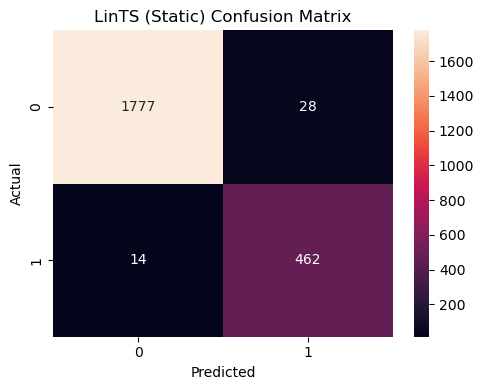

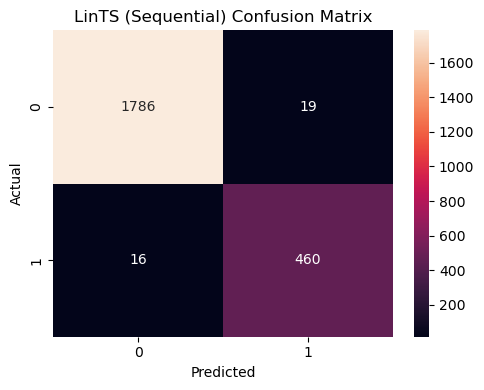

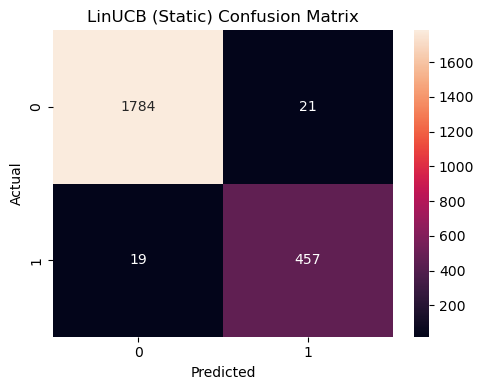

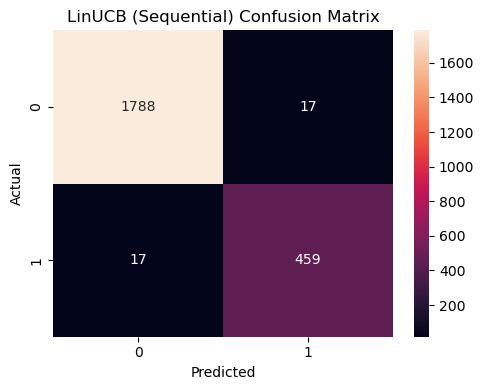

In [ ]:
# =========================
# Hybrid DL + Contextual Bandits (Static & Sequential) End-to-End
# =========================
import os
import time
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier


import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Bidirectional, Flatten, Input
from tensorflow.keras.optimizers import Adam

file_path = os.path.join("Data", "Hybrid_Augmented_TSAFE_Features.xlsx")
df = pd.read_excel(file_path)

if 'Plant_Destination' not in df.columns:
    if {'Plant Code', 'Destination Port'}.issubset(df.columns):
        df['Plant_Destination'] = (
            df['Plant Code'].astype(str) + ' | ' + df['Destination Port'].astype(str)
        )
    else:
        raise ValueError("Cannot create 'Plant_Destination' because 'Plant Code' or 'Destination Port' is missing.")

cat_features = [
    'Origin Port',
    'Carrier',
    'Plant Code',
    'Destination Port',
    'Plant_Destination',
]

num_features = [
    'Unit quantity', 'Weight', 'TPT',
    'TPT_per_Unit', 'LeadTime_Deviation', 'Weight_per_Unit', 'log_UnitQty',
    'carrier_origin_risk', 'route_cum_late_rate', 'route_bb_mean', 'carrier_bb_mean',
    'route_orders_last7d', 'route_roll10_Weight_q90',
    'congestion_trend', 'Weight_vsCarrierMean', 'seq_pos_norm',
]

requested_cols = cat_features + num_features
missing = [c for c in requested_cols if c not in df.columns]
if missing:
    print(f"[WARN] Missing columns skipped: {missing}")
    cat_features = [c for c in cat_features if c in df.columns]
    num_features = [c for c in num_features if c in df.columns]

X = pd.get_dummies(df[cat_features + num_features], drop_first=False)
y = (df['Ship Late Day count'] > 0).astype(int)


X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)


def calculate_metrics(y_true, y_score_or_pred):
    arr = np.asarray(y_score_or_pred).reshape(-1)
    if set(np.unique(arr)) <= {0,1}:
        y_pred = arr.astype(int)
    else:
        y_pred = (arr >= 0.5).astype(int)
    return {
        'Accuracy':  accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=1),
        'Recall':    recall_score(y_true, y_pred, average='weighted', zero_division=1),
        'F1-Score':  f1_score(y_true, y_pred, average='weighted', zero_division=1)
    }


xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    param_grid={'n_estimators':[100], 'max_depth':[3,5], 'learning_rate':[0.1,0.05], 'subsample':[0.8]},
    scoring='roc_auc', cv=3, n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_proba = xgb.best_estimator_.predict_proba(X_test)[:, 1]
xgb_metrics = calculate_metrics(y_test, xgb_proba)


def create_model(model_type, input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim, 1)))
    if model_type == 'CNN':
        model.add(Conv1D(64, 2, activation='relu'))
        model.add(Flatten())
    elif model_type == 'LSTM':
        model.add(LSTM(64, activation='tanh'))
    elif model_type == 'Bi-LSTM':
        model.add(Bidirectional(LSTM(64, activation='tanh')))
    elif model_type == 'Stacked LSTM':
        model.add(LSTM(64, activation='tanh', return_sequences=True))
        model.add(LSTM(32, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=1e-3, clipnorm=1.0), loss='binary_crossentropy')
    return model

X_train_dl = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_dl  = X_test_scaled.reshape(-1,  X_test_scaled.shape[1],  1)

dl_models = ['CNN', 'LSTM', 'Bi-LSTM', 'Stacked LSTM']
results = []
dl_outputs = {}

for m in dl_models:
    mdl = create_model(m, X_train_dl.shape[1])
    t0 = time.time()
    mdl.fit(X_train_dl, y_train_res, epochs=10, batch_size=256, verbose=0)
    duration = round(time.time() - t0, 2)
    proba = mdl.predict(X_test_dl, verbose=0).reshape(-1)
    dl_outputs[m] = proba
    met = calculate_metrics(y_test, proba)
    met.update({'Model': m, 'Time (s)': duration})
    results.append(met)

xgb_met = xgb_metrics.copy()
xgb_met.update({'Model': 'XGBoost', 'Time (s)': 0.0})
results.append(xgb_met)

expert_names = ['xgb', 'CNN', 'LSTM', 'Bi-LSTM', 'Stacked LSTM']
expert_proba_static_raw = np.vstack([
    xgb_proba,
    dl_outputs['CNN'],
    dl_outputs['LSTM'],
    dl_outputs['Bi-LSTM'],
    dl_outputs['Stacked LSTM']
]).T.astype(np.float32)  # (n_test, 5)

context_static = MinMaxScaler().fit_transform(expert_proba_static_raw).astype(np.float32)
labels_static = y_test.values.astype(int)


meta_cols = [c for c in ['Order Date','Origin Port','Destination Port','Carrier'] if c in df.columns]
if len(meta_cols) < 4:
    df_fallback = df.copy()
    if 'Order Date' not in df_fallback.columns:
        df_fallback['Order Date'] = pd.Timestamp('2000-01-01')
    for cc in ['Origin Port','Destination Port','Carrier']:
        if cc not in df_fallback.columns:
            df_fallback[cc] = 'UNK'
    base_df = df_fallback
else:
    base_df = df

test_idx = X_test.index
test_frame = base_df.loc[test_idx, ['Order Date','Origin Port','Destination Port','Carrier']].copy()
test_frame['Order Date'] = pd.to_datetime(test_frame['Order Date'], errors='coerce').fillna(pd.Timestamp('2000-01-01'))

test_frame['y']   = labels_static
test_frame['xgb'] = xgb_proba
for m in dl_models:
    test_frame[m] = dl_outputs[m]

test_frame['route_key'] = (
    test_frame['Origin Port'].astype(str) + ' | ' +
    test_frame['Destination Port'].astype(str) + ' | ' +
    test_frame['Carrier'].astype(str)
)
test_frame = test_frame.sort_values('Order Date').reset_index(drop=True)

expert_proba_seq_raw = test_frame[['xgb','CNN','LSTM','Bi-LSTM','Stacked LSTM']].values.astype(np.float32)
context_seq = MinMaxScaler().fit_transform(expert_proba_seq_raw).astype(np.float32)
labels_seq  = test_frame['y'].values.astype(int)


def _reward_cls(y_true, y_pred, tp=2.0, tn=1.0, fn=-5.0, fp=-2.0):
    if y_true == y_pred:
        return tp if y_true == 1 else tn
    return fn if (y_true == 1 and y_pred == 0) else fp

def linTS_expert_select(X_ctx, y, expert_probs, alpha_prior=1.0, lambda_reg=1e-3, seed=42):
    """
    Linear Thompson Sampling over experts (actions).
    X_ctx: (n,d) context (scaled expert probs), d=5
    y:     (n,) labels {0,1}
    expert_probs: (n,K) raw expert probabilities, K=5
    Returns: chosen_actions (n,), pred_labels (n,)
    """
    rng = np.random.RandomState(seed)
    n, d = X_ctx.shape
    K = expert_probs.shape[1]
    A = [lambda_reg * np.eye(d) for _ in range(K)]  # precision
    b = [np.zeros(d) for _ in range(K)]             # reward-weighted sums

    chosen, preds = [], []
    for i in range(n):
        x = X_ctx[i]
        utilities = []
        for a in range(K):
            A_inv = np.linalg.inv(A[a])
            mu = A_inv @ b[a]
            cov = alpha_prior * A_inv
            theta = rng.multivariate_normal(mu, cov)
            utilities.append(theta @ x)
        a_hat = int(np.argmax(utilities))
        chosen.append(a_hat)

     
        y_pred = 1 if expert_probs[i, a_hat] >= 0.5 else 0
        preds.append(y_pred)

        r = _reward_cls(int(y[i]), y_pred)
        A[a_hat] += np.outer(x, x)
        b[a_hat] += r * x
    return np.array(chosen), np.array(preds)

def linUCB_expert_select(X_ctx, y, expert_probs, alpha=1.0, lambda_reg=1e-3):
    """
    LinUCB over experts (actions) with ridge regression + UCB bonus.
    """
    n, d = X_ctx.shape
    K = expert_probs.shape[1]
    A = [lambda_reg * np.eye(d) for _ in range(K)]
    b = [np.zeros(d) for _ in range(K)]

    chosen, preds = [], []
    for i in range(n):
        x = X_ctx[i]
        scores = []
        for a in range(K):
            A_inv = np.linalg.inv(A[a])
            theta = A_inv @ b[a]
            ucb = alpha * np.sqrt(x @ A_inv @ x)
            scores.append(theta @ x + ucb)
        a_hat = int(np.argmax(scores))
        chosen.append(a_hat)

        y_pred = 1 if expert_probs[i, a_hat] >= 0.5 else 0
        preds.append(y_pred)

        r = _reward_cls(int(y[i]), y_pred)
        A[a_hat] += np.outer(x, x)
        b[a_hat] += r * x
    return np.array(chosen), np.array(preds)


t0 = time.time()
acts_ts_static, preds_ts_static = linTS_expert_select(
    context_static, labels_static, expert_proba_static_raw,
    alpha_prior=1.0, lambda_reg=1e-3, seed=42
)
ts_time_static = round(time.time() - t0, 2)
ts_metrics_static = calculate_metrics(labels_static, preds_ts_static)
ts_metrics_static.update({'Model': 'Contextual Bandit LinTS (Expert Select, Static)', 'Time (s)': ts_time_static})
results.append(ts_metrics_static)

t0 = time.time()
acts_ucb_static, preds_ucb_static = linUCB_expert_select(
    context_static, labels_static, expert_proba_static_raw,
    alpha=1.0, lambda_reg=1e-3
)
ucb_time_static = round(time.time() - t0, 2)
ucb_metrics_static = calculate_metrics(labels_static, preds_ucb_static)
ucb_metrics_static.update({'Model': 'Contextual Bandit LinUCB (Expert Select, Static)', 'Time (s)': ucb_time_static})
results.append(ucb_metrics_static)


t0 = time.time()
acts_ts_seq, preds_ts_seq = linTS_expert_select(
    context_seq, labels_seq, expert_proba_seq_raw,
    alpha_prior=1.0, lambda_reg=1e-3, seed=42
)
ts_time_seq = round(time.time() - t0, 2)
ts_metrics_seq = calculate_metrics(labels_seq, preds_ts_seq)
ts_metrics_seq.update({'Model': 'Contextual Bandit LinTS (Expert Select, Sequential)', 'Time (s)': ts_time_seq})
results.append(ts_metrics_seq)

t0 = time.time()
acts_ucb_seq, preds_ucb_seq = linUCB_expert_select(
    context_seq, labels_seq, expert_proba_seq_raw,
    alpha=1.0, lambda_reg=1e-3
)
ucb_time_seq = round(time.time() - t0, 2)
ucb_metrics_seq = calculate_metrics(labels_seq, preds_ucb_seq)
ucb_metrics_seq.update({'Model': 'Contextual Bandit LinUCB (Expert Select, Sequential)', 'Time (s)': ucb_time_seq})
results.append(ucb_metrics_seq)

results_df = pd.DataFrame(results)
print("\n=== Results (DL, XGB, Bandits Static/Sequential) ===")
print(results_df.sort_values('F1-Score', ascending=False).to_string(index=False))

results_df.to_csv('model_comparison_contextual_bandits.csv', index=False)


plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(labels_static, preds_ts_static), annot=True, fmt='d')
plt.title("LinTS (Static) Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(labels_seq, preds_ts_seq), annot=True, fmt='d')
plt.title("LinTS (Sequential) Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(labels_static, preds_ucb_static), annot=True, fmt='d')
plt.title("LinUCB (Static) Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(labels_seq, preds_ucb_seq), annot=True, fmt='d')
plt.title("LinUCB (Sequential) Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()
